Silhouette Score (sin ruido): 0.120


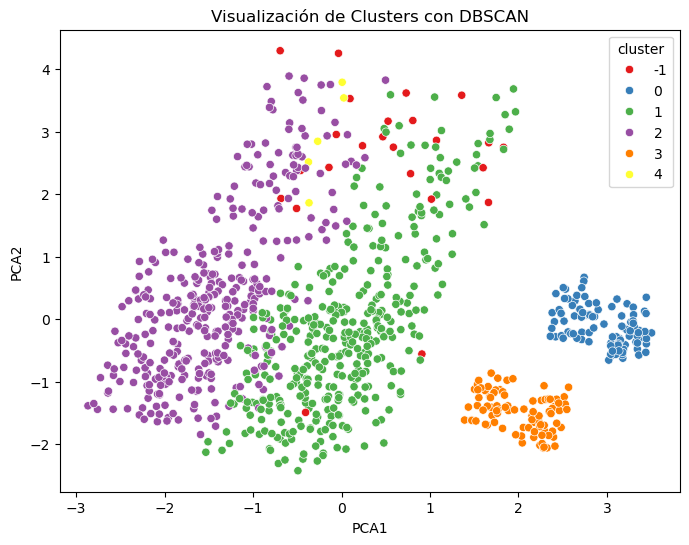


Distribución de puntos por cluster (incluyendo ruido):
cluster
 1    392
 2    361
 0    101
 3     90
-1     24
 4      5
Name: count, dtype: int64

Perfil promedio de cada cluster (valores reales):
           Age  Weight (kg)  Height (m)    BMI  Fat_Percentage  \
cluster                                                          
0        38.13        85.25        1.80  26.56           12.38   
1        38.58        73.01        1.71  24.91           27.41   
2        39.10        71.82        1.73  24.08           27.72   
3        38.47        60.17        1.64  22.72           17.50   
4        23.60       111.78        1.69  39.19           26.36   

         Experience_Level  Workout_Frequency (days/week)  
cluster                                                   
0                     3.0                           4.54  
1                     2.0                           3.54  
2                     1.0                           2.46  
3                     3.0                

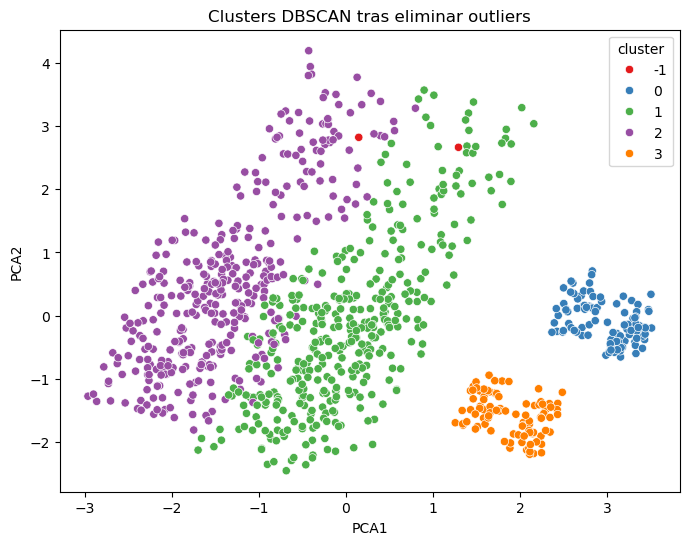


Distribución por cluster (tras eliminar outliers):
cluster
 1    386
 2    362
 0    101
 3     90
-1      2
Name: count, dtype: int64

Perfil promedio de cada cluster (sin outliers):
           Age  Weight (kg)  Height (m)    BMI  Fat_Percentage  \
cluster                                                          
0        38.13        85.25        1.80  26.56           12.38   
1        38.74        71.98        1.72  24.30           27.50   
2        38.79        71.52        1.72  24.00           27.72   
3        38.47        60.17        1.64  22.72           17.50   

         Experience_Level  Workout_Frequency (days/week)  
cluster                                                   
0                     3.0                           4.54  
1                     2.0                           3.53  
2                     1.0                           2.48  
3                     3.0                           4.52  
✅ Dataset limpio guardado como 'dataset_dbscan_sin_outliers.csv'

In [20]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Paso 2: Cargar el dataset
dataset = pd.read_csv("archivo_gym_members_exercise_tracking_version2.csv")

# Paso 3: Seleccionar variables y escalar
features = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Fat_Percentage',
            'Experience_Level', 'Workout_Frequency (days/week)']

X = dataset[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 4: Aplicar DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Añadir cluster al dataset
dataset['cluster'] = labels

# Paso 5: Evaluar Silhouette (ignorando ruido)
mask = labels != -1
if mask.sum() > 1:
    sil_score = silhouette_score(X_scaled[mask], labels[mask])
    print(f"Silhouette Score (sin ruido): {sil_score:.3f}")
else:
    print("Muy pocos clusters válidos para calcular Silhouette.")

# Paso 6: Visualización con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_plot = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_plot['cluster'] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='Set1', data=df_plot)
plt.title("Visualización de Clusters con DBSCAN")
plt.show()

# Paso 7: Ver distribución de puntos por cluster
print("\nDistribución de puntos por cluster (incluyendo ruido):")
print(dataset['cluster'].value_counts())

# Paso 8: Perfil promedio de cada cluster (excluyendo ruido)
print("\nPerfil promedio de cada cluster (valores reales):")
print(dataset[dataset['cluster'] != -1].groupby('cluster')[features].mean().round(2))

# Paso 9: Guardar dataset con clusters
#dataset.to_csv("dataset_con_clusters_dbscan.csv", index=False)

# ============================
# PASO EXTRA: Eliminar outliers con IQR y repetir DBSCAN
# ============================

# Función para eliminar outliers con IQR
def remove_outliers_iqr(df, features):
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Aplicar limpieza de outliers
filtered_dataset = remove_outliers_iqr(dataset.copy(), features)
print(f"\nRegistros tras eliminar outliers: {filtered_dataset.shape[0]}")

# Escalar los datos filtrados
X_filtered_scaled = scaler.fit_transform(filtered_dataset[features])

# Aplicar DBSCAN nuevamente
dbscan_filtered = DBSCAN(eps=1.27, min_samples=3)
labels_filtered = dbscan_filtered.fit_predict(X_filtered_scaled)
filtered_dataset['cluster'] = labels_filtered

# Evaluar silhouette nuevamente
mask_filtered = labels_filtered != -1
if mask_filtered.sum() > 1:
    sil_score_filtered = silhouette_score(X_filtered_scaled[mask_filtered], labels_filtered[mask_filtered])
    print(f"Silhouette Score (sin ruido, tras limpiar outliers): {sil_score_filtered:.3f}")
else:
    print("Muy pocos clusters válidos tras filtrar para calcular Silhouette.")

# Visualización PCA
pca_filtered = PCA(n_components=2)
pca_result_filtered = pca_filtered.fit_transform(X_filtered_scaled)
df_plot_filtered = pd.DataFrame(pca_result_filtered, columns=['PCA1', 'PCA2'])
df_plot_filtered['cluster'] = labels_filtered

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='Set1', data=df_plot_filtered)
plt.title("Clusters DBSCAN tras eliminar outliers")
plt.show()

# Distribución y perfil
print("\nDistribución por cluster (tras eliminar outliers):")
print(filtered_dataset['cluster'].value_counts())

print("\nPerfil promedio de cada cluster (sin outliers):")
print(filtered_dataset[filtered_dataset['cluster'] != -1].groupby('cluster')[features].mean().round(2))

import joblib

# Filtrar los puntos con cluster diferente de -1
df_final = filtered_dataset[filtered_dataset['cluster'] != -1]

# Guardar dataset limpio con 4 clusters (0, 1, 2, 3)
df_final.to_csv("dataset_dbscan_sin_outliers.csv", index=False)

# Guardar scaler y modelo si se necesitan después
joblib.dump(scaler, "scaler.pkl")
joblib.dump(dbscan_filtered, "dbscan_model.pkl")

print("✅ Dataset limpio guardado como 'dataset_dbscan_sin_outliers.csv' (sin puntos -1).")
